## Notebook to plot histogram and example of SME injection periods and following quiet periods

@author Riley Troyer
science@rileytroyer.com

In [2]:
# Libraries
from datetime import datetime
from dateutil import parser
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import scipy.stats as stats
from sklearn.utils import resample
import sys

# Add root to path
path_root = Path('../../').resolve()
sys.path.append(str(path_root))

# Function to read in PFISR data
from src.data.sme_functions import sme_read_process

In [3]:
# Read in the data file
quiet_times = pd.read_csv('../../data/interim/sme-injections-quiet-times.txt', delimiter=',',
                          names=['Quiet Start', 'Quiet End', 'Injection Start',
                                 'Injection Length', 'Quiet Length']) 

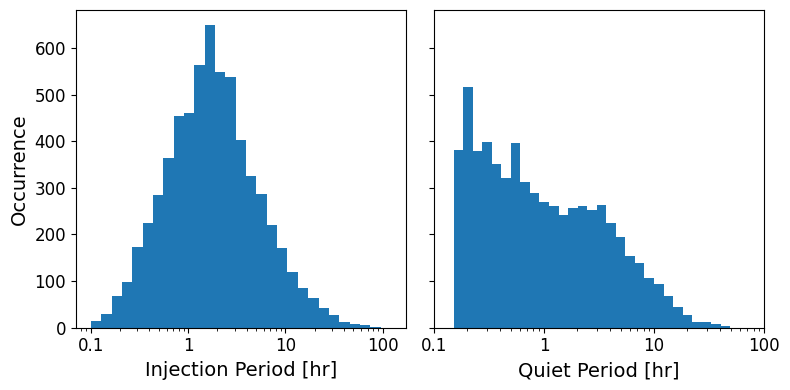

In [3]:
# Plot histogram of injection and quiet period lengths

# Create histogram for injection length and quiet period length
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Data to plot for quiet times
y_injection = quiet_times.loc[:, 'Injection Length']/3600
y_quiet = quiet_times.loc[:, 'Quiet Length']/3600

# Construct bins
n_bins = 30
bins_injection = np.logspace(np.log10(np.nanmin(y_injection)), 
                             np.log10(np.nanmax(y_injection)), n_bins)
bins_quiet = np.logspace(np.log10(np.nanmin(y_quiet)), 
                         np.log10(np.nanmax(y_quiet)), n_bins)

# Plot the histograms
axs[0].hist(y_injection, bins=bins_injection)
axs[1].hist(y_quiet, bins=bins_quiet)

# Setup titles and axis
axs[0].set_xlabel('Injection Period [hr]', fontsize=14)
axs[1].set_xlabel('Quiet Period [hr]', fontsize=14)
axs[0].set_ylabel('Occurrence', fontsize=14)
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([0.1, 1, 10, 100])
axs[0].set_xticklabels([0.1, 1, 10, 100], fontsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[1].set_xticks([0.1, 1, 10, 100])
axs[1].set_xticklabels([0.1, 1, 10, 100], fontsize=12)

plt.tight_layout()

plt.savefig('../../reports/presentation-figures/injection-quiet_periods-hist.jpg', dpi=300)

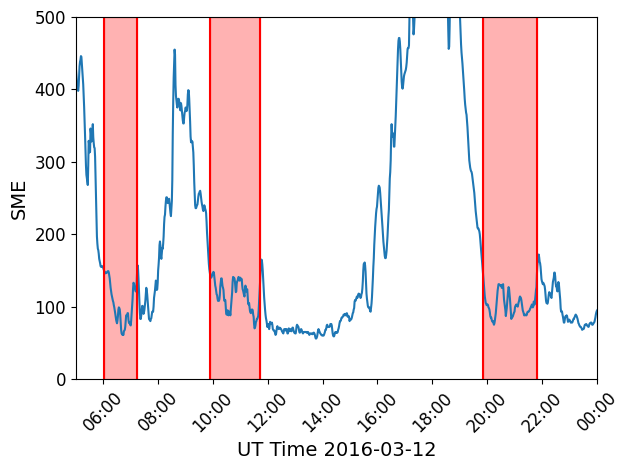

In [13]:
# Which event to plot
event = 3090
date = parser.isoparse(quiet_times.loc[event, 'Quiet Start'])

# Read in the correct sme index datafile
sme_smooth, sme_dates = sme_read_process(f'../../data/raw/sme/{date.year}.txt')

# Plot SME indices
fig, ax = plt.subplots()
ax.plot(sme_dates, sme_smooth)

# Limits of time to plot
x_low = datetime(date.year, date.month, date.day, 5)
x_high = datetime(date.year, date.month, date.day+1, 0)
ax.set_xlim(x_low, x_high)  
ax.set_ylim(0, 500)

# Add lines for start and stop times
indication_times = [parser.isoparse(d) for d in quiet_times.loc[:, 'Quiet Start']]
indication_times.extend([parser.isoparse(d) for d in quiet_times.loc[:, 'Quiet End']])
indication_times = np.array(sorted(indication_times))

selected_quiet_times = indication_times[(indication_times > x_low) & (indication_times < x_high)]
ax.vlines(selected_quiet_times, 0, 500, color='red')

# Fill between lines
ax.fill_between([selected_quiet_times[0], selected_quiet_times[1]],
                y1=0, y2=500, alpha=0.3, color='red')
ax.fill_between([selected_quiet_times[2], selected_quiet_times[3]],
                y1=0, y2=500, alpha=0.3, color='red')
ax.fill_between([selected_quiet_times[4], selected_quiet_times[5]],
                y1=0, y2=500, alpha=0.3, color='red')

# Axis
half_hours = mdates.MinuteLocator(interval = 120)
# ax.xaxis.set_minor_locator(half_hours)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(half_hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.tick_params(axis='x', which='major', labelsize=12,
               labelrotation=45)
ax.tick_params(axis='y', which='major', labelsize=12)

# Labels
ax.set_ylabel('SME', fontsize=14)
ax.set_xlabel('UT Time {}'.format(date.date()), 
              fontsize=14)

plt.tight_layout()

#plt.savefig('../../reports/figures/sme-injection-example.jpg', dpi=300)